<a href="https://colab.research.google.com/github/Nanfemicit/EOS-Course/blob/main/Copy_of_Extreme_precipitation_CHELSA_excersise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrem value analysis Tenerife precipitation

This script analyzes **spatial and temporal precipitation data** using **daily precipitation records**, focusing on **extreme value events**.

In [30]:
#Install some libaries first!
!pip install xclim
!pip install lmoments3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00


In [31]:
#Import need libaries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import lmoments3
from lmoments3 import distr

from xclim.core.missing import missing_pct
from xclim.indices.generic import select_resample_op
from xclim.indices.stats import fa, fit, frequency_analysis, parametric_quantile
import gdown

#Download data

We utilize precipitation data from [CHELSA](https://chelsa-climate.org/), a high-resolution climate dataset derived from downscaled ERA5 reanalysis data. A preprocessed dataset is available for download from Google Drive:

In [32]:
# Download CHELSA precipitation data from Google Drive
#'GOOGLE_DRIVE_LINK' to NetCDF file
url = 'https://drive.google.com/file/d/1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd/view?usp=drive_link'
# Download the NetCDF file
file_path = 'CHELSA_precipitation.nc'
gdown.download(url, file_path, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd
From (redirected): https://drive.google.com/uc?id=1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd&confirm=t&uuid=76979033-0258-41af-9833-d6160a9a7ebb
To: /content/CHELSA_precipitation.nc
100%|██████████| 325M/325M [00:07<00:00, 41.2MB/s]


'CHELSA_precipitation.nc'

#Load data

Since this dataset contains spatial and temporal data, forming a 3D data cube, we will use [XArray](https://docs.xarray.dev/en/stable/), a specialized data protocol designed for handling multi-dimensional scientific data efficiently. To begin, we will open the NetCDF file using XArray:

In [33]:
#Load precipitation data as XArray
daily_precipitation = xr.open_dataset(file_path)
daily_precipitation

<xarray.Dataset> Size: 325MB
Dimensions:  (time: 5114, lat: 77, lon: 103)
Coordinates:
  * time     (time) datetime64[ns] 41kB 2003-01-01 2003-01-02 ... 2016-12-31
  * lat      (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon      (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
Data variables:
    tp       (time, lat, lon) float64 324MB ...
Attributes:
    units:    mm/d

In [34]:
# create a array which only conains the years - we need this later
years = daily_precipitation['time'].dt.year.values

#Generate precipitation maps

Next, we will generate, plot, and save maps displaying the mean total annual precipitation and the mean annual variance of precipitation over the given time period.

In [35]:
# Calcualte mean total annual precipitation
# first group by year and sum up values
annual_total_precipitation = daily_precipitation.groupby('time.year').sum(dim='time')
# second calaculate the mean
annual_total_precipitation_mean = annual_total_precipitation.mean(dim='year')

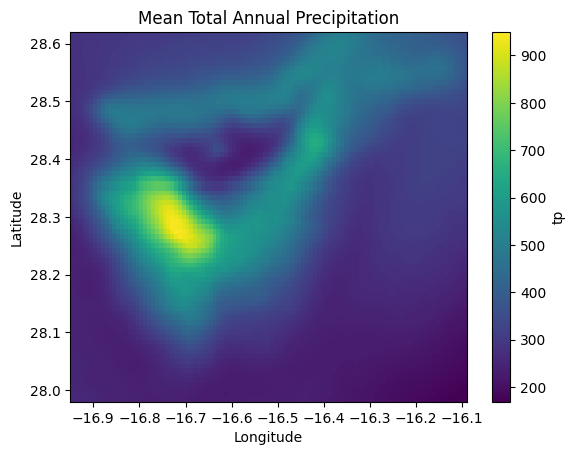

In [36]:
# Plot the map of mean total annual precipitation
annual_total_precipitation_mean['tp'].plot.imshow()
plt.title('Mean Total Annual Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [37]:
# Calcualte mean annual variance of precipitation
annual_var_precipitation = daily_precipitation.groupby('time.year').var(dim='time')
annual_var_precipitation_mean = annual_var_precipitation.mean(dim='year')

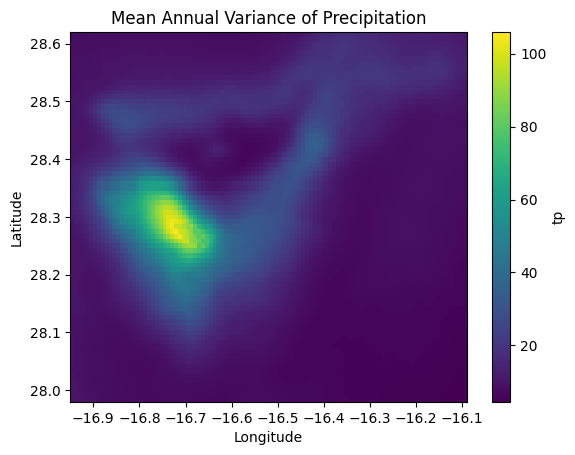

In [38]:
# Plot the map of mean annual variance precipitation
annual_var_precipitation_mean['tp'].plot.imshow()
plt.title('Mean Annual Variance of Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [39]:
# Store the mean and variance maps as netcdf file
filename = 'CHELSA_Tenerife_mean_total_precipitation_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
annual_total_precipitation_mean.to_netcdf(filename)
filename = 'CHELSA_Tenerife_mean_variance_precipitation_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
annual_var_precipitation_mean.to_netcdf(filename)

# **Extreme Value Analysis**

In this section, we will perform an **Extreme Value Analysis (EVA)** to assess extreme precipitation events. The following steps will be carried out:

- **Calculate the block maxima** with an **annual frequency** for each pixel.
- **Fit the Generalized Extreme Value (GEV) distribution** to these maxima for each pixel. *(Note: Depending on the selected method, this step may take some time to compute.)*
- **Estimate extreme precipitation events** corresponding to **5-, 15-, 25-, and 50-year return periods**.
- **Generate complete maps** of expected extreme precipitation events using **QGIS**, incorporating the **Tenerife Shapefile** for spatial context.

To accomplish this, we will utilize the [**xclim library**](https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html), which is already imported in the script header. This library provides specialized tools for climate indices and frequency analysis, facilitating our calculations.

In [42]:
# Use the libary xclim (https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html)
# to optain the Block Maxima with yearly frequency
# Resample daily precipitation to yearly maxima using xarray
# Compute annual maximum precipitation using xarray resampling
# Compute annual maximum precipitation
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmoments3 import distr
from xclim.indices.stats import fit, parametric_quantile, fa
from xclim.indices.generic import select_resample_op
# Load precipitation data
file_path = 'CHELSA_precipitation.nc'
daily_precipitation = xr.open_dataset(file_path)['tp']  # Adjust variable name if needed


# Step 1: Compute Block Maxima (Annual Maximum Precipitation)
annual_max_precip = daily_precipitation.resample(time='YS').max()


In [43]:
# We use the xclim libary to fit GEV function (dist=dist.gev)
# Therefore, we can select from a broad range of fitting methods:
# - Maximum Likelihood algorithm (method="ML") - Default but very sensetive to outliers
# - Method of Moments (method="MM") - not working with our data
# - Maximum Likelihood Estimation (method="MLE") - kind of similar but diffrent to ML
# - Probability Weighted Moments (method="PWM") - More robust to oulierts!
# PWM is well suited for small samples which in our case make it the prefered method.

# Fit the Generalized Extreme Value (GEV) distribution using PWM method
gev_params = fit(annual_max_precip, dist=distr.gev, method="PWM")


print(gev_params)


<xarray.DataArray 'tp' (dparams: 3, lat: 77, lon: 103)> Size: 190kB
array([[[ 3.03610068e-02,  1.00530403e-02, -1.72760847e-03, ...,
          1.88989619e-01,  1.86274485e-01,  1.93057323e-01],
        [-2.06454435e-02, -3.44637588e-02, -3.51305382e-02, ...,
          1.12036017e-01,  1.00824528e-01,  1.12554700e-01],
        [-7.44565142e-02, -8.14938690e-02, -7.77301246e-02, ...,
          8.45151929e-02,  6.59530390e-02,  7.64448509e-02],
        ...,
        [ 1.62910800e-01,  1.86277770e-01,  2.16042946e-01, ...,
          6.24193605e-02,  2.90367127e-02,  3.06738044e-02],
        [ 1.74412237e-01,  2.03728365e-01,  2.23835432e-01, ...,
          9.42184424e-02,  6.97280084e-02,  7.56012632e-02],
        [ 1.83991515e-01,  2.01103401e-01,  2.05695735e-01, ...,
          1.15380734e-01,  1.12440319e-01,  1.31780138e-01]],

       [[ 2.40537855e+01,  2.43235812e+01,  2.45923708e+01, ...,
          3.15162039e+01,  3.10623461e+01,  3.06113225e+01],
        [ 2.37356300e+01,  2.410205

In [47]:
# We use the xclim libary to extract the quantile value for a given return period
# as input we need:
# - the previously fitted parameters (params) of the distribution function
# - the quatinetile we are interested in which relates to the probability of excedance (q = 1-P = 1-1/tau)

# Define return periods (tau)
return_periods = [5, 10, 25, 50]
quantiles = {tau: parametric_quantile(gev_params, q=1-1/tau) for tau in return_periods}

# Check the keys of the dictionary
print(quantiles.keys())

# Extract a specific return period (e.g., 10-year return period)
quantile_10yr = quantiles["return_value"][1]  # Adjust the index accordingly


dict_keys([5, 10, 25, 50])


KeyError: 'return_value'

Return period 5 years: <xarray.DataArray 'tp' (quantile: 1, lat: 77, lon: 103)> Size: 63kB
array([[[39.65089024, 39.75566081, 39.67367217, ..., 52.99410156,
         52.42516325, 52.00668347],
        [39.37123964, 39.50886235, 39.54761705, ..., 53.39932758,
         52.51494016, 51.87946366],
        [39.10431645, 39.25471062, 39.31269764, ..., 54.28456791,
         53.10936272, 52.25657082],
        ...,
        [50.92619755, 49.76970413, 48.59943507, ..., 36.63541174,
         36.26469371, 36.1940987 ],
        [50.62766707, 50.06945456, 49.27778252, ..., 36.75268882,
         36.32216221, 36.1806268 ],
        [49.92049661, 49.96925361, 49.70359428, ..., 37.16019261,
         36.77279301, 36.566706  ]]])
Coordinates:
  * lat       (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon       (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * quantile  (quantile) float64 8B 0.8
Attributes:
    long_name:     genextreme quantiles
    description:   Qua

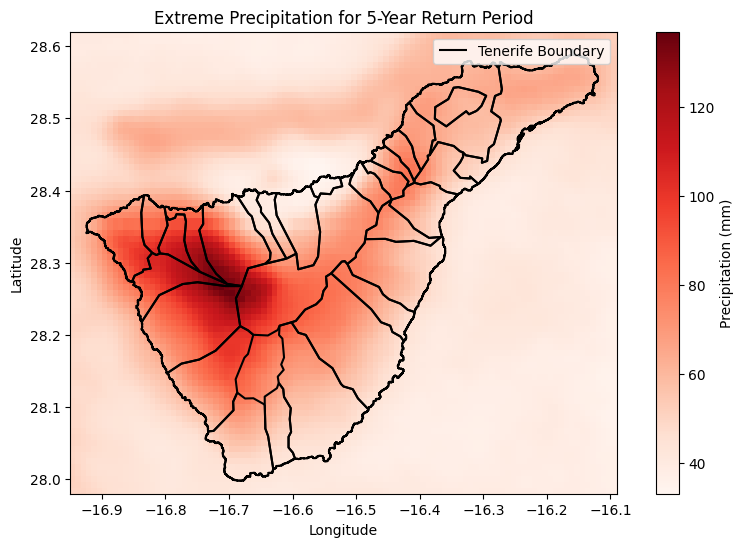

Saved: extreme_precipitation_5yr.png
Return period 10 years: <xarray.DataArray 'tp' (quantile: 1, lat: 77, lon: 103)> Size: 63kB
array([[[47.1916374 , 47.38951054, 47.23360099, ..., 61.65943822,
         61.07105957, 60.5983658 ],
        [47.37741689, 47.52106882, 47.3532273 , ..., 63.29186985,
         62.42127637, 61.57435964],
        [47.58371054, 47.69209665, 47.51434804, ..., 64.79071752,
         63.6461882 , 62.52564597],
        ...,
        [60.16428948, 58.39231483, 56.54171364, ..., 44.56666159,
         44.46873522, 44.32024538],
        [59.61919609, 58.51244379, 57.25558593, ..., 44.28656052,
         43.98849973, 43.69194638],
        [58.5759384 , 58.34175239, 57.91504868, ..., 44.50861817,
         44.01195021, 43.49306701]]])
Coordinates:
  * lat       (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon       (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * quantile  (quantile) float64 8B 0.9
Attributes:
    long_name:     genex

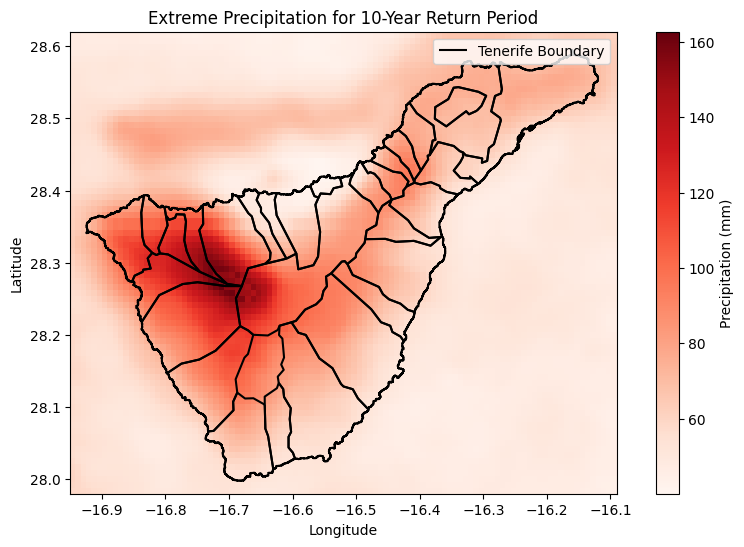

Saved: extreme_precipitation_10yr.png
Return period 25 years: <xarray.DataArray 'tp' (quantile: 1, lat: 77, lon: 103)> Size: 63kB
array([[[56.47697357, 56.95291149, 56.79961698, ..., 70.98920316,
         70.40125116, 69.81712684],
        [57.6722407 , 57.94537827, 57.51450326, ..., 74.65862276,
         73.91239663, 72.70912458],
        [58.99770315, 59.11780277, 58.58528819, ..., 77.14706569,
         76.23503441, 74.68601345],
        ...,
        [70.33217971, 67.69735201, 64.90002265, ..., 54.0709235 ,
         54.58217943, 54.32376095],
        [69.42003917, 67.49045887, 65.59629987, ..., 53.07468742,
         53.11858452, 52.59301156],
        [67.93444836, 67.26454791, 66.63237727, ..., 52.92826245,
         52.32705907, 51.31979706]]])
Coordinates:
  * lat       (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon       (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * quantile  (quantile) float64 8B 0.96
Attributes:
    long_name:     gen

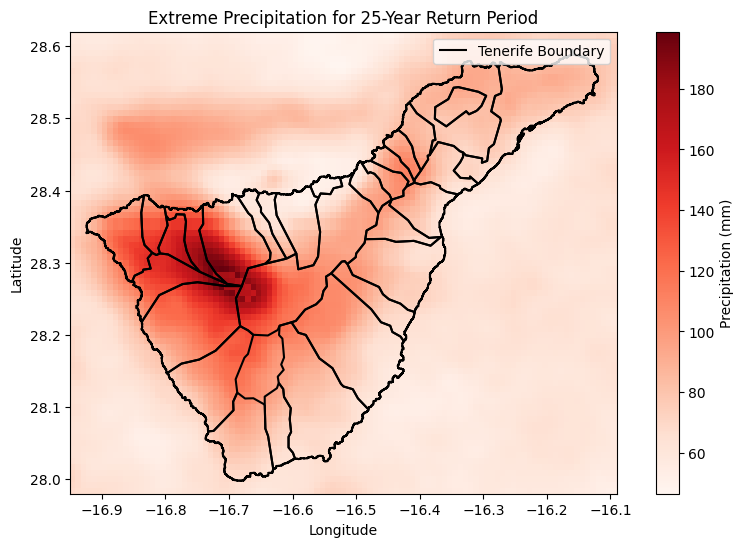

Saved: extreme_precipitation_25yr.png
Return period 50 years: <xarray.DataArray 'tp' (quantile: 1, lat: 77, lon: 103)> Size: 63kB
array([[[63.19470547, 63.98892288, 63.90636525, ..., 76.90688592,
         76.33258988, 75.64464129],
        [65.44079552, 65.9018177 , 65.27444574, ..., 82.34434959,
         81.75479989, 80.23475192],
        [68.00138124, 68.18308292, 67.34192343, ..., 85.69474321,
         85.0784772 , 83.15455247],
        ...,
        [76.92288154, 73.61268354, 70.08345072, ..., 60.7670624 ,
         61.90704454, 61.55920798],
        [75.71236323, 73.11559695, 70.73534205, ..., 59.10530391,
         59.51229069, 58.7960897 ],
        [73.89510082, 72.86732011, 72.08524321, ..., 58.60550142,
         57.94750538, 56.52590013]]])
Coordinates:
  * lat       (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon       (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * quantile  (quantile) float64 8B 0.98
Attributes:
    long_name:     gen

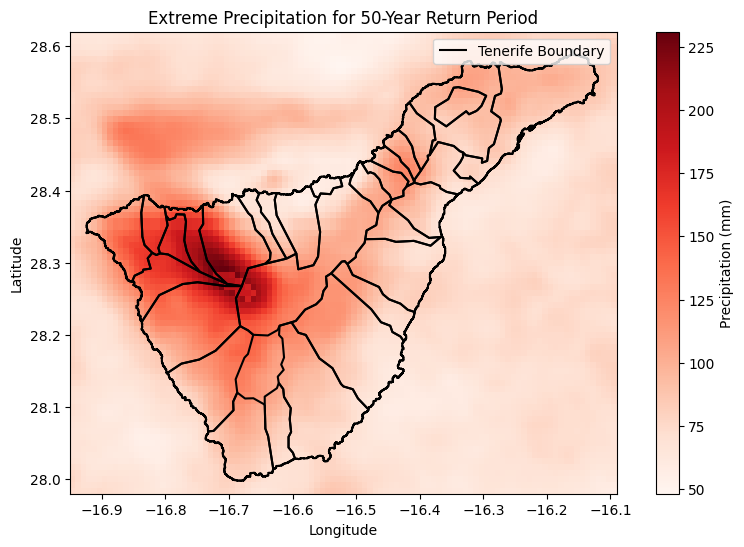

Saved: extreme_precipitation_50yr.png


In [48]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Load the Tenerife municipality CSV
municipality_data = pd.read_csv("/content/ESP_adm4.csv")

# Define full list of Tenerife municipalities from QGIS
tenerife_municipalities = [
    'Adeje', 'Arafo', 'Arico', 'Arona', 'Buenavista del Norte', 'Candelaria',
    'El Rosario', 'El Sauzal', 'El Tanque', 'Fasnia', 'Garachico',
    'Granadilla de Abona', 'Guía de Isora', 'Icod de los Vinos', 'La Guancha',
    'La Matanza de Acentejo', 'La Orotava', 'La Victoria de Acentejo',
    'Los Realejos', 'Los Silos', 'Puerto de la Cruz', 'San Cristóbal de La Laguna',
    'San Juan de la Rambla', 'San Miguel de Abona', 'Santa Cruz de Tenerife',
    'Santa Úrsula', 'Santiago del Teide', 'Tacoronte', 'Tegueste',
    'Vilaflor de Chasna', 'Villa de Arico', 'Güímar'
]

# Filter the CSV to include only Tenerife municipalities
tenerife_data = municipality_data[municipality_data["NAME_4"].isin(tenerife_municipalities)]

# Load the Tenerife shapefile
tenerife_shapefile = gpd.read_file("SINGLE TENERIFE.shp")

# Filter shapefile using the CSV municipality list
tenerife_boundary = tenerife_shapefile[tenerife_shapefile["NAME_4"].isin(tenerife_municipalities)]

# Iterate over all return periods and plot
for tau in quantiles.keys():  # Iterate over return periods
    quantile = quantiles[tau]  # Extract the corresponding value
    print(f"Return period {tau} years: {quantile}")

    if isinstance(quantile, xr.Dataset):
        quantile = quantile.to_array().isel(variable=0)  # Convert to DataArray

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot precipitation data with red colormap
    quantile.plot(ax=ax, cmap="Reds", cbar_kwargs={"label": "Precipitation (mm)"})

    # Plot Tenerife boundary in black outline
    tenerife_boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, label="Tenerife Boundary")

    # Labels and Title
    plt.title(f"Extreme Precipitation for {tau}-Year Return Period")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Save the figure as PNG with high resolution
    output_filename = f"extreme_precipitation_{tau}yr.png"
    plt.savefig(output_filename, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.legend()
    plt.show()

    print(f"Saved: {output_filename}")  # Confirmation message

